In [113]:
#Let's make this work for hockey.

In [114]:
#load test hockey data
import pandas as pd
actions=pd.read_csv('data_nwhl.csv')
data=pd.read_csv('data_nwhl.csv')

#for plots
import socceraction.spadl.config as spadlconfig
from socceraction.spadl.base import SPADLSchema

In [115]:
#Load modules
from typing import Callable, List, Tuple
import numpy as np  
from pandera.typing import DataFrame, Series
try:
    from scipy.interpolate import interp2d 
except ImportError:
    interp2d = None
M: int = 12
N: int = 16

In [116]:
def _get_cell_indexes(x: Series, y: Series, l: int = N, w: int = M) -> Tuple[Series, Series]:
    xmin = 0
    ymin = 0
    xi = (x - xmin) / 200 * l 
    yj = (y - ymin) / 85 * w  
    xi = xi.astype(int).clip(0, l - 1)
    yj = yj.astype(int).clip(0, w - 1)
    return xi, yj
#test
xi, yj = _get_cell_indexes(actions.start_x, actions.start_y, l=16, w=12)

In [117]:
def _get_flat_indexes(x: Series, y: Series, l: int = N, w: int = M) -> Series:
    xi, yj = _get_cell_indexes(x, y, l, w)
    return l * (w - 1 - yj) + xi 
#test
_get_flat_indexes(x=actions.start_x, y=actions.start_y, l=16,w=12)

0         88
1        104
2        138
3        138
4        157
        ... 
26877     48
26878     48
26879      2
26880    186
26881    186
Length: 26882, dtype: int32

In [118]:
def _count(x: Series, y: Series, l: int = N, w: int = M) -> np.ndarray:
    """Count the number of actions occurring in each cell of the grid.
    Parameters
    ----------
    x : pd.Series
        The x-coordinates of the actions.
    y : pd.Series
        The y-coordinates of the actions.
    l : int
        Amount of grid cells in the x-dimension of the grid.
    w : int
        Amount of grid cells in the y-dimension of the grid.

    Returns
    -------
    np.ndarray
        A matrix, denoting the amount of actions occurring in each cell. The
        top-left corner is the origin.
    """
    #first it gets rid of nan values
    x = x[~np.isnan(x) & ~np.isnan(y)]
    y = y[~np.isnan(x) & ~np.isnan(y)]
    flat_indexes = _get_flat_indexes(x, y, l, w)
    vc = flat_indexes.value_counts(sort=False)
    vector = np.zeros(w * l) 
    vector[vc.index] = vc 
    return vector.reshape((w, l)) 
#Example using data
test_mtrx=_count(actions.start_x, actions.start_y, l=16, w= 12)

In [119]:
def _safe_divide(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    return np.divide(a, b, out=np.zeros_like(a), where=b != 0)

In [120]:
def scoring_prob(actions, l: int = N, w: int = M) -> np.ndarray:
    """Compute the probability of scoring when taking a shot for each cell.

    Parameters
    ----------
    actions : pd.DataFrame
        Actions, in SPADL format.
    l : int
        Amount of grid cells in the x-dimension of the grid.
    w : int
        Amount of grid cells in the y-dimension of the grid.

    Returns
    -------
    np.ndarray
        A matrix, denoting the probability of scoring for each cell.
    """
    actions=actions[actions['success'].isna() == False]
    actions=actions[actions['end_x'].isna() == False]
    shot_actions = actions[(actions.type_name == 'Shot')]
    goals = shot_actions[(shot_actions.success == 1.0)]
    
    shotmatrix = _count(shot_actions.start_x, shot_actions.start_y, l, w)
    goalmatrix = _count(goals.start_x, goals.start_y, l, w)
    return _safe_divide(goalmatrix, shotmatrix)
score_prob_mtrx = scoring_prob(actions, l=16,w=12)

In [121]:
def get_move_actions(actions):
    """Get all ball-progressing actions.

    These include passes, dribbles and crosses. Take-ons are ignored because
    they typically coincide with dribbles and do not move the ball to
    a different cell.

    Parameters
    ----------
    actions : pd.DataFrame
        Actions, in SPADL format.

    Returns
    -------
    pd.DataFrame
        All ball-progressing actions in the input dataframe.
    """
    actions=actions[actions['success'].isna() == False]
    actions=actions[actions['end_x'].isna() == False]
    return actions[
        (actions.type_name == 'Faceoff') # I assume this is similar to dribble
        | (actions.type_name == 'Zone Entry') #not sure, I assume
        | (actions.type_name == 'Pass') # this is similar to pass
        #| (actions.type_name == 'Puck Recovery') I think it shouldn't count
    ]

#These are the posisble events in hockey data:
#  [1] "Faceoff Win"     "Puck Recovery"   "Zone Entry"     
#  [4] "Shot"            "Play"            "Takeaway"       
#  [7] "Dump In/Out"     "Incomplete Play" "Penalty Taken"  
# [10] "Goal"

#These are the possible events in soccer data:
# 'pass', 'dribble', 'throw_in', 'shot', 'bad_touch', 'clearance',
# 'foul', 'freekick_short', 'cross', 'goalkick', 'shot_freekick',
# 'corner_crossed', 'take_on', 'tackle', 'corner_short',
# 'interception', 'keeper_save', 'keeper_claim', 'freekick_crossed',
# 'keeper_punch', 'shot_penalty'

#these are the events that the socccer model takes as move actions:
# (actions.type_name == 'pass')
# (actions.type_name == 'dribble')
# (actions.type_name == 'cross')
ma=get_move_actions(actions)

In [122]:
def get_successful_move_actions(actions):
    """Get all successful ball-progressing actions.

    These include successful passes, dribbles and crosses.

    Parameters
    ----------
    actions : pd.DataFrame
        Actions, in SPADL format.

    Returns
    -------
    pd.DataFrame
        All ball-progressing actions in the input dataframe.
    """
    actions=actions[actions['success'].isna() == False]
    actions=actions[actions['end_x'].isna() == False]
    move_actions = get_move_actions(actions)
    return move_actions[move_actions.success == 1.0]
sma=get_successful_move_actions(actions)

In [123]:
def action_prob(
    actions, l: int = N, w: int = M
) -> Tuple[np.ndarray, np.ndarray]:
    """Compute the probability of taking an action in each cell of the grid.

    The options are: shooting or moving.

    Parameters
    ----------
    actions : pd.DataFrame
        Actions, in SPADL format.
    l : pd.DataFrame
        Amount of grid cells in the x-dimension of the grid.
    w : pd.DataFrame
        Amount of grid cells in the y-dimension of the grid.

    Returns
    -------
    shotmatrix : np.ndarray
        For each cell the probability of choosing to shoot.
    movematrix : np.ndarray
        For each cell the probability of choosing to move.
    """
    actions=actions[actions['success'].isna() == False]
    actions=actions[actions['end_x'].isna() == False]
    move_actions = get_move_actions(actions)
    shot_actions = actions[(actions.type_name == 'Shot')]

    movematrix = _count(move_actions.start_x, move_actions.start_y, l, w)
    shotmatrix = _count(shot_actions.start_x, shot_actions.start_y, l, w)
    totalmatrix = movematrix + shotmatrix

    return _safe_divide(shotmatrix, totalmatrix), _safe_divide(movematrix, totalmatrix)
s_p,m_p = action_prob(actions,l=16,w=12)

In [124]:
def move_transition_matrix(actions, l: int = N, w: int = M) -> np.ndarray:
    """Compute the move transition matrix from the given actions.

    This is, when a player chooses to move, the probability that he will
    end up in each of the other cells of the grid successfully.

    Parameters
    ----------
    actions : pd.DataFrame
        Actions, in SPADL format.
    l : int
        Amount of grid cells in the x-dimension of the grid.
    w : int
        Amount of grid cells in the y-dimension of the grid.

    Returns
    -------
    np.ndarray
        The transition matrix.
    """
    actions=actions[actions['success'].isna() == False]
    actions=actions[actions['end_x'].isna() == False]
    move_actions = get_move_actions(actions)

    X = pd.DataFrame()
    X['start_cell'] = _get_flat_indexes(move_actions.start_x, move_actions.start_y, l, w)
    X['end_cell'] = _get_flat_indexes(move_actions.end_x, move_actions.end_y, l, w)
    X['success'] = move_actions.success

    vc = X.start_cell.value_counts(sort=False)
    start_counts = np.zeros(w * l)
    start_counts[vc.index] = vc

    transition_matrix = np.zeros((w * l, w * l))

    for i in range(0, w * l):
        vc2 = X[((X.start_cell == i) & (X.success == 1.0))].end_cell.value_counts(
            sort=False
        )
        transition_matrix[i, vc2.index] = vc2 / start_counts[i]

    return transition_matrix

mtm = move_transition_matrix(actions,l=16,w=12)

In [125]:
#This should technically work

In [126]:
class ExpectedThreat:
    """An implementation of the Expected Threat (xT) model [Singh2019]_.

    Parameters
    ----------
    l : int
        Amount of grid cells in the x-dimension of the grid.
    w : int
        Amount of grid cells in the y-dimension of the grid.
    eps : float
       The desired precision to calculate the xT value of a cell. Default is
       5 decimal places of precision (1e-5).

    Attributes
    ----------
    l : int
        Amount of grid cells in the x-dimension of the grid.
    w : int
        Amount of grid cells in the y-dimension of the grid.
    eps : float
       The desired precision to calculate the xT value of a cell. Default is
       5 decimal places of precision (1e-5).
    heatmaps : list(np.ndarray)
        The i-th element corresponds to the xT value surface after i iterations.
    xT : np.ndarray
        The final xT value surface.
    scoring_prob_matrix : np.ndarray, shape(M,N)
        The probability of scoring when taking a shot for each cell.
    shot_prob_matrix : np.ndarray, shape(M,N)
        The probability of choosing to shoot for each cell.
    move_prob_matrix : np.ndarray, shape(M,N)
        The probability of choosing to move for each cell.
    transition_matrix : np.ndarray, shape(M*N,M*N)
        When moving, the probability of moving to each of the other zones.


    .. [Singh2019] Singh, Karun. "Introducing Expected Threat (xT)." 15 February, 2019.
        https://karun.in/blog/expected-threat.html
    """

    def __init__(self, l: int = N, w: int = M, eps: float = 1e-5):
        self.l = l
        self.w = w
        self.eps = eps
        self.heatmaps: List[np.ndarray] = []
        self.xT: np.ndarray = np.zeros((w, l))
        self.scoring_prob_matrix: np.ndarray = np.zeros((w, l))
        self.shot_prob_matrix: np.ndarray = np.zeros((w, l))
        self.move_prob_matrix: np.ndarray = np.zeros((w, l))
        self.transition_matrix: np.ndarray = np.zeros((w * l, w * l))

    def __solve(
        self,
        p_scoring: np.ndarray,
        p_shot: np.ndarray,
        p_move: np.ndarray,
        transition_matrix: np.ndarray,
    ) -> None:
        """Solves the expected threat equation with dynamic programming.

        Parameters
        ----------
        p_scoring : (np.ndarray, shape(M, N)):
            Probability of scoring at each grid cell, when shooting from that cell.
        p_shot : (np.ndarray, shape(M,N)):
            For each grid cell, the probability of choosing to shoot from there.
        p_move : (np.ndarray, shape(M,N)):
            For each grid cell, the probability of choosing to move from there.
        transition_matrix : (np.ndarray, shape(M*N,M*N)):
            When moving, the probability of moving to each of the other zones.
        """
        gs = p_scoring * p_shot
        diff = 1
        it = 0
        self.heatmaps.append(self.xT.copy())

        while np.any(diff > self.eps):
            total_payoff = np.zeros((self.w, self.l))

            for y in range(0, self.w):
                for x in range(0, self.l):
                    for q in range(0, self.w):
                        for z in range(0, self.l):
                            total_payoff[y, x] += (
                                transition_matrix[self.l * y + x, self.l * q + z] * self.xT[q, z]
                            )

            newxT = gs + (p_move * total_payoff)
            diff = newxT - self.xT
            self.xT = newxT
            self.heatmaps.append(self.xT.copy())
            it += 1

        print('# iterations: ', it)

    def fit(self, actions) -> 'ExpectedThreat':
        """Fits the xT model with the given actions.

        Parameters
        ----------
        actions : pd.DataFrame
            Actions, in SPADL format.

        Returns
        -------
        self
            Fitted xT model.
        """
        self.scoring_prob_matrix = scoring_prob(actions, self.l, self.w)
        self.shot_prob_matrix, self.move_prob_matrix = action_prob(actions, self.l, self.w)
        self.transition_matrix = move_transition_matrix(actions, self.l, self.w)
        self.__solve(
            self.scoring_prob_matrix,
            self.shot_prob_matrix,
            self.move_prob_matrix,
            self.transition_matrix,
        )
        return self

    def interpolator(self, kind: str = 'linear') -> Callable[[np.ndarray, np.ndarray], np.ndarray]:
        """Interpolate over the pitch.

        This is a wrapper around :func:`scipy.interpolate.interp2d`.

        Parameters
        ----------
        kind : {'linear', 'cubic', 'quintic'}, optional
            The kind of spline interpolation to use. Default is ‘linear’.

        Returns
        -------
        callable
            A function that interpolates xT values over the pitch.
        """
        if interp2d is None:
            raise ImportError('Interpolation requires scipy to be installed.')

        cell_length = 200 / self.l
        cell_width = 85 / self.w

        x = np.arange(0.0, 200, cell_length) + 0.5 * cell_length
        y = np.arange(0.0, 85, cell_width) + 0.5 * cell_width

        return interp2d(x=x, y=y, z=self.xT, kind=kind, bounds_error=False)

    def predict(
        self, actions, use_interpolation: bool = False
    ) -> np.ndarray:
        """Predicts the xT values for the given actions.

        Parameters
        ----------
        actions : pd.DataFrame
            Actions, in SPADL format.
        use_interpolation : bool
            Indicates whether to use bilinear interpolation when inferring xT
            values. Note that this requires Scipy to be installed (pip install
            scipy).

        Returns
        -------
        np.ndarray
            The xT value for each action.
        """
        if not use_interpolation:
            l = self.l
            w = self.w
            grid = self.xT
        else:
            # Use interpolation to create a
            # more fine-grained 1050 x 680 grid
            interp = self.interpolator()
            l = int(spadlconfig.field_length * 10)
            w = int(spadlconfig.field_width * 10)
            xs = np.linspace(0, 200, l)
            ys = np.linspace(0, 85, w)
            grid = interp(xs, ys)

        startxc, startyc = _get_cell_indexes(actions.start_x, actions.start_y, l, w)
        endxc, endyc = _get_cell_indexes(actions.end_x, actions.end_y, l, w)

        xT_start = grid[w - 1 - startyc, startxc]
        xT_end = grid[w - 1 - endyc, endxc]

        return xT_end - xT_start

In [127]:
xTModel = ExpectedThreat(l=16, w=12) # seems like we can specify the number of areas 
# which is cool
xTModel.fit(data)

# iterations:  15


In [128]:
mov_actions = get_successful_move_actions(data)
mov_actions["xT_value"] = xTModel.predict(mov_actions)

In [129]:
#We have a problem. when preparing data we need to change how 
# x and y is at posetion teams perspective.
#We need to normalize as it all teams are facing the same way
#How can we do that?
mov_actions[
    ["Team","type_name", "start_x", "start_y", "end_x", "end_y", "xT_value"]
][:10]

,Team,type_name,start_x,start_y,end_x,end_y,xT_value
2,Boston Pride,Zone Entry,125,28,131.0,28.0,0.000000
4,Boston Pride,Faceoff,169,21,159.0,26.0,0.012978
7,Minnesota Whitecaps,Zone Entry,125,6,157.0,0.0,0.001243
8,Minnesota Whitecaps,Pass,157,0,198.0,38.0,0.015589
9,Minnesota Whitecaps,Pass,193,20,196.0,33.0,0.002390
11,Boston Pride,Pass,3,49,37.0,70.0,0.000190
17,Boston Pride,Pass,12,33,61.0,85.0,0.000696
19,Minnesota Whitecaps,Zone Entry,124,2,162.0,2.0,0.001795
22,Boston Pride,Pass,25,3,57.0,3.0,0.000725
25,Minnesota Whitecaps,Pass,79,80,105.0,45.0,-0.000040


In [130]:
#Top 10 teams
print("Top 10 offenses in terms of xT:")
pd.DataFrame(
    mov_actions.groupby('Team')['xT_value'].sum()
            ).sort_values(
    by='xT_value',ascending=False
                         ).head(10)

Top 10 offenses in terms of xT:


,xT_value
Team,
Boston Pride,8.366766
Toronto Six,6.860559
Buffalo Beauts,3.430373
Minnesota Whitecaps,3.209424
Connecticut Whale,2.990447
Metropolitan Riveters,1.762150


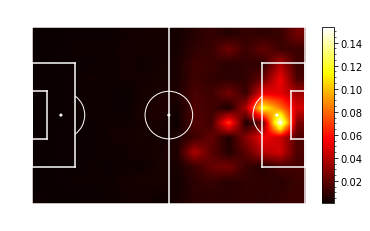

In [180]:
import matplotsoccer as mps

interp = xTModel.interpolator()
x = np.linspace(0, 200, 200*4)
y = np.linspace(0, 85, 85*4)
mps.heatmap(interp(x,y), cmap="hot", linecolor="white", cbar="True")

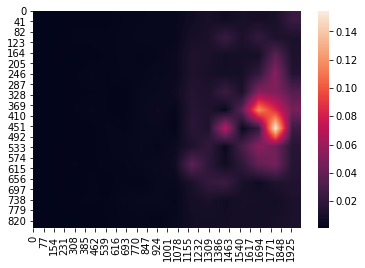

In [139]:
import seaborn as sns
sns.heatmap(interp(x,y))

In [133]:
from sports_plotter.hockey import Rink

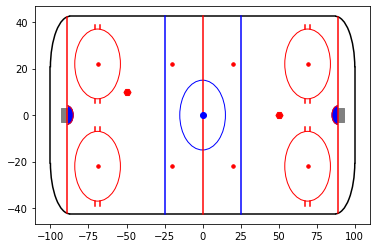

In [134]:
rink = Rink(vert=True)
rink = Rink(half=True)
rink = Rink(half=True, vert=True)
fig, ax = plt.subplots(1,1)
rnk = Rink()
rnk.add_shots([[50,0],[-50,10]], shape='H', color='red')
rnk.plot_rink(ax)
#sns.heatmap(interp(x,y))
plt.show()

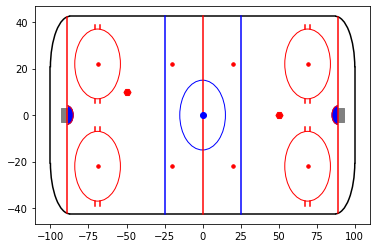

In [135]:
fig, ax = plt.subplots(1,1)
rnk = Rink()
rnk.add_shots([[50,0],[-50,10]], shape='H', color='red')
rnk.plot_rink(ax)
plt.show()

In [136]:
interp = xTModel.interpolator()

In [206]:
x = np.linspace(0, 200, 2000)
y = np.linspace(0, 85, 850)

In [207]:
matrix = interp(x,y)

In [208]:
#np.savetxt("matrix.csv", matrix, delimiter=",")

In [209]:
frame = pd.DataFrame(matrix)

In [215]:
m_lst = []
n_lst = []
p_lst = []
for m in frame.columns:
    for n in frame.index:
        p_lst.append(frame[m][n])
        m_lst.append(m)
        n_lst.append(n)
export=pd.DataFrame(data={'x':m_lst,'y':n_lst,'xt':p_lst})
export.to_csv('frame_plot.csv',index=False)